In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

from joblib import dump, load

import shap
import lime
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import MinMaxScaler

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
import tensorflow as tf

In [4]:
file_path = '/Users/ameeshi/Desktop/fyp/data/FX_FanU_new.xlsx'
df = pd.read_excel(file_path)
df['DATE'] = pd.to_datetime(df['DATE'])

df_sg = df.drop(columns = ['SGD', 'KRONA', 'YEN', 'EURO', 'POUND', 'FRANC'])

df_sg['DATE'] = df_sg['DATE'].astype(str)
df_sg['DATE'] = df_sg['DATE'].str.split(' ').str[0]
df_sg.rename(columns={'DATE': 'Date'}, inplace=True)

df_sg.reset_index(drop = True)
# df_sg.to_csv("fx_filtered_sg.csv", index=False)

# Normalize the 'EURO' column
scaler = MinMaxScaler(feature_range=(0, 1))
df_sg['CAD'] = scaler.fit_transform(df_sg['CAD'].values.reshape(-1, 1))

df_sg_train = df_sg[(df_sg['Date'] >= '2017-12-25') & (df_sg['Date'] <= '2018-12-31')]
df_sg_test = df_sg[(df_sg['Date'] >= '2020-01-01')]

In [5]:
df_sg_train

,Date,CAD
516,2017-12-25,0.281757
517,2017-12-26,0.262464
518,2017-12-27,0.246418
519,2017-12-28,0.218720
520,2017-12-29,0.195033
...,...,...
777,2018-12-25,0.599236
778,2018-12-26,0.605731
779,2018-12-27,0.618529
780,2018-12-28,0.617383


In [6]:
# List of currencies
currencies = ['CAD']

# Dictionary to store cumulative accuracies
cumulative_accuracies = {}

In [7]:
# Function to create lag features
def create_lag_features(df, lag=5):
    df_new = pd.DataFrame(index=df.index)
    for i in range(lag+1):
        if i == 0:
            df_new[f'{currencies}_t'] = df[currencies].values
        else:
            df_new[f'{currencies}_t-{i}'] = df[currencies].shift(i).values
    df_new.dropna(inplace=True)
    return df_new

In [8]:
lag = 5  # You can adjust this
train_df_lagged = create_lag_features(df_sg_train, lag=lag)
test_df_lagged = create_lag_features(df_sg_test, lag=lag)

In [9]:
train_df_lagged

,['CAD']_t,['CAD']_t-1,['CAD']_t-2,['CAD']_t-3,['CAD']_t-4,['CAD']_t-5
521,0.195033,0.195033,0.218720,0.246418,0.262464,0.281757
522,0.185673,0.195033,0.195033,0.218720,0.246418,0.262464
523,0.197517,0.185673,0.195033,0.195033,0.218720,0.246418
524,0.194078,0.197517,0.185673,0.195033,0.195033,0.218720
525,0.143840,0.194078,0.197517,0.185673,0.195033,0.195033
...,...,...,...,...,...,...
777,0.599236,0.599236,0.586246,0.563324,0.534670,0.544222
778,0.605731,0.599236,0.599236,0.586246,0.563324,0.534670
779,0.618529,0.605731,0.599236,0.599236,0.586246,0.563324
780,0.617383,0.618529,0.605731,0.599236,0.599236,0.586246


In [10]:
# Separating features and labels
X_train_fx = train_df_lagged.iloc[:, 1:].values  # All lag features
y_train_fx = train_df_lagged.iloc[:, 0].values  # Current value to predict

X_test_fx = test_df_lagged.iloc[:, 1:].values
y_test_fx = test_df_lagged.iloc[:, 0].values


# dates = create_dataset(df_sg_train)

X_train_fx = np.reshape(X_train_fx, (X_train_fx.shape[0], X_train_fx.shape[1], 1))

In [11]:
# Extract and store the 'Date' column
dates = df_sg_train['Date']
test_dates = df_sg_test['Date']

In [12]:
# to match the rates prediction columns with the dates
dates = dates[5:]


In [13]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_fx.shape[1], 1)))
model.add(Dense(1))
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train_fx, y_train_fx, epochs=30, batch_size=1, verbose=2) 

Epoch 1/30
261/261 - 1s - loss: 0.0051 - 676ms/epoch - 3ms/step
Epoch 2/30
261/261 - 0s - loss: 0.0010 - 156ms/epoch - 596us/step
Epoch 3/30
261/261 - 0s - loss: 0.0010 - 157ms/epoch - 602us/step
Epoch 4/30
261/261 - 0s - loss: 0.0012 - 157ms/epoch - 603us/step
Epoch 5/30
261/261 - 0s - loss: 0.0011 - 221ms/epoch - 846us/step
Epoch 6/30
261/261 - 0s - loss: 0.0013 - 159ms/epoch - 608us/step
Epoch 7/30
261/261 - 0s - loss: 9.1303e-04 - 154ms/epoch - 591us/step
Epoch 8/30
261/261 - 0s - loss: 9.9814e-04 - 151ms/epoch - 577us/step
Epoch 9/30
261/261 - 0s - loss: 0.0010 - 152ms/epoch - 581us/step
Epoch 10/30
261/261 - 0s - loss: 9.1041e-04 - 160ms/epoch - 611us/step
Epoch 11/30
261/261 - 0s - loss: 8.9385e-04 - 159ms/epoch - 609us/step
Epoch 12/30
261/261 - 0s - loss: 0.0010 - 153ms/epoch - 588us/step
Epoch 13/30
261/261 - 0s - loss: 9.3422e-04 - 157ms/epoch - 600us/step
Epoch 14/30
261/261 - 0s - loss: 8.6706e-04 - 154ms/epoch - 589us/step
Epoch 15/30
261/261 - 0s - loss: 9.2902e-04 - 156

In [14]:
# Predicting for all dates in the dataset 
y_pred_train = model.predict(X_train_fx)

9/9 [==============================] - 0s 592us/step


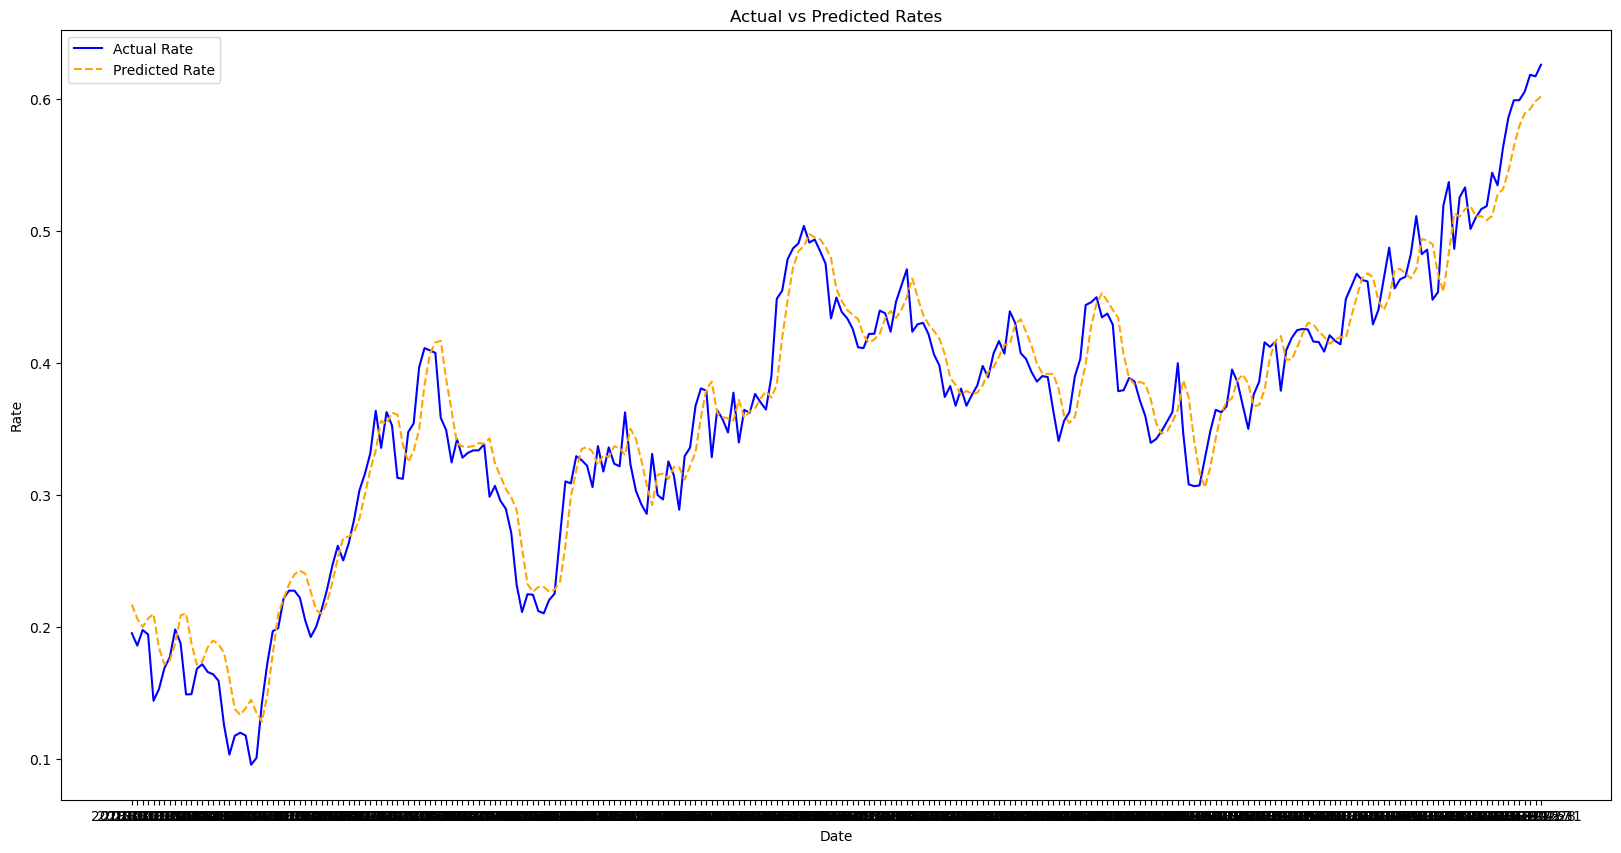

In [15]:
# for plot
plt.figure(figsize=(20,10))
plt.plot(dates, y_train_fx, label='Actual Rate', color='blue')
plt.plot(dates, y_pred_train, label='Predicted Rate', linestyle='--', color='orange')
plt.title(f'Actual vs Predicted Rates')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.show()

In [16]:
# for test dataset
X_test_fx = np.reshape(X_test_fx, (X_test_fx.shape[0], X_test_fx.shape[1], 1))
y_pred_test = model.predict(X_test_fx)


18/18 [==============================] - 0s 486us/step


In [17]:


test_error_mse = mean_squared_error(y_test_fx, y_pred_test)
print(f"Test MSE: {test_error_mse}")

test_error_rmse = np.sqrt(test_error_mse)
print(f"Test RMSE: { test_error_rmse}")

test_r2 = r2_score(y_test_fx, y_pred_test)
print(f"Test r2 score: {test_r2}")

Test MSE: 0.0011856289720381286
Test RMSE: 0.034432963451293715
Test r2 score: 0.9715778127959652


In [18]:
# adjusting test dates to match the prediction rate correctly
adjusted_test_dates = test_dates[lag:] 
adjusted_test_dates = adjusted_test_dates[:len(y_pred_test)]

In [19]:
actual_with_dates = {date: actual for date, actual in zip(adjusted_test_dates, y_test_fx)}

# Printing the first few items to verify
for date, actual in list(actual_with_dates.items())[:5]:
    print(f"Date: {date}, Actual: {actual}")

Date: 2020-01-08, Actual: 0.3887297039159501
Date: 2020-01-09, Actual: 0.4116523400191019
Date: 2020-01-10, Actual: 0.3944603629417385
Date: 2020-01-13, Actual: 0.3948424068767906
Date: 2020-01-14, Actual: 0.39980897803247384


In [20]:
# Creating a dictionary to store predictions with their corresponding date
predictions_with_dates = {date: prediction for date, prediction in zip(adjusted_test_dates, y_pred_test)}

# Printing the first few items to verify
for date, prediction in list(predictions_with_dates.items())[:5]:
    print(f"Date: {date}, Prediction: {prediction}")

Date: 2020-01-08, Prediction: [0.37878507]
Date: 2020-01-09, Prediction: [0.38740957]
Date: 2020-01-10, Prediction: [0.4043089]
Date: 2020-01-13, Prediction: [0.40573642]
Date: 2020-01-14, Prediction: [0.4025986]


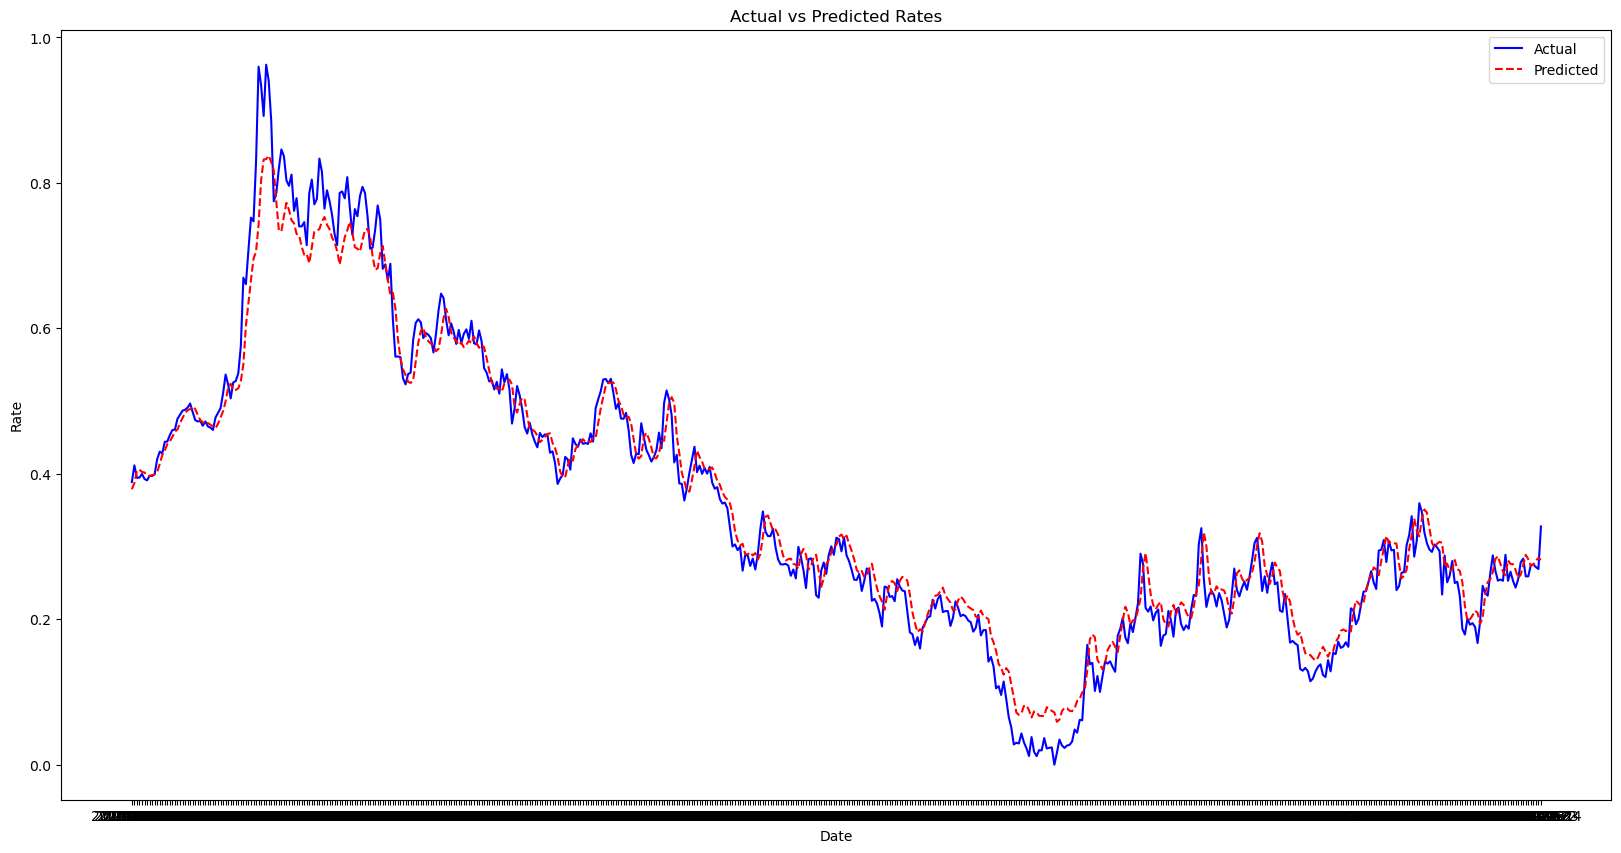

In [21]:
# Plotting the predicted rates
plt.figure(figsize=(20,10))
plt.plot(adjusted_test_dates, y_test_fx, label=f'Actual', linestyle='-', color='blue')
plt.plot(adjusted_test_dates, y_pred_test, label=f'Predicted', linestyle='--', color='red')

plt.title('Actual vs Predicted Rates')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend(loc='best')
plt.show()

In [22]:
dtypes = {'RegionName': str, 'RegionCode': str}
file_path_oxford = '/Users/ameeshi/Desktop/fyp/OxCGRT_nat_latest.xlsx'  # Update this path
df_oxford = pd.read_excel(file_path_oxford, dtype=dtypes)



In [23]:
df_oxford.head()

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1M_School closing,C1M_Flag,C2M_Workplace closing,C2M_Flag,...,MajorityVaccinated,PopulationVaccinated,StringencyIndex_Average,StringencyIndex_Average_ForDisplay,GovernmentResponseIndex_Average,GovernmentResponseIndex_Average_ForDisplay,ContainmentHealthIndex_Average,ContainmentHealthIndex_Average_ForDisplay,EconomicSupportIndex,EconomicSupportIndex_ForDisplay
0,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200101,0.0,NaN,0.0,NaN,...,NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200102,0.0,NaN,0.0,NaN,...,NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200103,0.0,NaN,0.0,NaN,...,NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200104,0.0,NaN,0.0,NaN,...,NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200105,0.0,NaN,0.0,NaN,...,NV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
interested_country = ['Canada']
# Filter for Canada
df_oxford_sg = df_oxford[df_oxford['CountryName'].isin(interested_country)]

# Change formatting of date
def convert_date(date):
    original_date = datetime.strptime(str(date), '%Y%m%d')
    formatted_date_str = original_date.strftime('%Y-%m-%d')
    return formatted_date_str

df_oxford_sg['Date'] = df_oxford_sg['Date'].apply(convert_date)

columns_to_drop = ["V1_Vaccine Prioritisation (summary)","V2A_Vaccine Availability (summary)","V2B_Vaccine age eligibility/availability age floor (general population summary)",
                   "V2C_Vaccine age eligibility/availability age floor (at risk summary)","V2D_Medically/ clinically vulnerable (Non-elderly)","V2E_Education",
                   "V2F_Frontline workers  (non healthcare)","V2G_Frontline workers  (healthcare)","V3_Vaccine Financial Support (summary)",
                   "V4_Mandatory Vaccination (summary)","ConfirmedDeaths","MajorityVaccinated","PopulationVaccinated",
                   "StringencyIndex_Average","GovernmentResponseIndex_Average","ContainmentHealthIndex_Average","EconomicSupportIndex",
                   "E1_Flag","H1_Flag","H7_Flag","C1M_Flag","C2M_Flag","C3M_Flag","C4M_Flag","C5M_Flag","C6M_Flag","C7M_Flag","H6M_Flag","H8M_Flag"]


# Select specified policy columns (N, R, T, etc. are placeholders for actual column names)
# coln_to_select = ['CURRENCY','CountryName','Date', 'C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events',
#     'C4_Restrictions on gatherings', 'C5_Close public transport', 
#     'C6_Stay at home requirements', 'C7_Restrictions on internal movement',
#     'C8_International travel controls', 'H1_Public information campaigns',
#     'H2_Testing policy', 'H3_Contact tracing', 'StringencyIndex', 'GovernmentResponseIndex']

# oxcg_filtered= df_oxford_sg[coln_to_select]

# Drop unwanted columns
oxcg_filtered = df_oxford_sg.drop(columns=columns_to_drop)



/var/folders/pv/j2j3lxvn5y76w14wslmbh_gc0000gn/T/ipykernel_34310/144353136.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_oxford_sg['Date'] = df_oxford_sg['Date'].apply(convert_date)


In [25]:

oxcg_filtered = oxcg_filtered[(oxcg_filtered['Date'] <= '2022-02-24')]

grouped = oxcg_filtered.groupby('CountryName')

# Fill missing values within each group
oxcg_filtered = grouped.apply(lambda group: group.fillna(method='bfill').fillna(method='ffill'))

# Reset the index to get a flat DataFrame
oxcg_filtered = oxcg_filtered.reset_index(drop=True)

In [26]:
country = {'CA': ['Canada', 'CAD']}

oxcg_filtered['DailyChange'] = oxcg_filtered["ConfirmedCases"].diff()
oxcg_filtered['DailyChange'] = oxcg_filtered['DailyChange'].fillna(0)

oxcg_filtered.drop(columns = "ConfirmedCases", inplace = True)

In [27]:
# making a new dataframe for predicted rates and the dates for merging 
rates_df = pd.DataFrame(list(predictions_with_dates.items()), columns = ['Date', 'PredRate'])
actualrate_df = pd.DataFrame(list(actual_with_dates.items()), columns = ['Date', 'ActualRate'])

merged_df = pd.merge(oxcg_filtered, rates_df, on='Date', how='inner')

In [28]:
merged_df = pd.merge(merged_df, actualrate_df, on = 'Date', how = 'inner')

In [29]:
merged_df

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1M_School closing,C2M_Workplace closing,C3M_Cancel public events,C4M_Restrictions on gatherings,...,H7_Vaccination policy,H8M_Protection of elderly people,M1_Wildcard,StringencyIndex_Average_ForDisplay,GovernmentResponseIndex_Average_ForDisplay,ContainmentHealthIndex_Average_ForDisplay,EconomicSupportIndex_ForDisplay,DailyChange,PredRate,ActualRate
0,Canada,CAN,NaN,NaN,NAT_TOTAL,2020-01-08,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.00,3.12,3.57,0.0,0.0,[0.37878507],0.388730
1,Canada,CAN,NaN,NaN,NAT_TOTAL,2020-01-09,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.00,3.12,3.57,0.0,0.0,[0.38740957],0.411652
2,Canada,CAN,NaN,NaN,NAT_TOTAL,2020-01-10,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.00,3.12,3.57,0.0,0.0,[0.4043089],0.394460
3,Canada,CAN,NaN,NaN,NAT_TOTAL,2020-01-13,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.00,3.12,3.57,0.0,0.0,[0.40573642],0.394842
4,Canada,CAN,NaN,NaN,NAT_TOTAL,2020-01-14,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,0.00,3.12,3.57,0.0,0.0,[0.4025986],0.399809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,Canada,CAN,NaN,NaN,NAT_TOTAL,2022-02-18,3.0,3.0,2.0,4.0,...,5.0,3.0,NaN,66.02,62.40,65.95,37.5,6747.0,[0.273601],0.274499
553,Canada,CAN,NaN,NaN,NAT_TOTAL,2022-02-21,2.0,2.0,1.0,4.0,...,5.0,2.0,NaN,54.16,54.89,57.38,37.5,3657.0,[0.27523324],0.275454
554,Canada,CAN,NaN,NaN,NAT_TOTAL,2022-02-22,2.0,2.0,1.0,4.0,...,5.0,2.0,NaN,54.15,54.88,57.37,37.5,7991.0,[0.28078163],0.271824
555,Canada,CAN,NaN,NaN,NAT_TOTAL,2022-02-23,2.0,2.0,1.0,4.0,...,5.0,2.0,NaN,54.14,54.88,57.37,37.5,9812.0,[0.28424448],0.269150


In [30]:
# train data
oxcg_filtered_train = merged_df[(merged_df['Date'] < '2021-01-01')]
oxcg_filtered_train = oxcg_filtered_train.reset_index(drop = True)

# test data
oxcg_filtered_test = merged_df[(merged_df['Date'] >= '2021-01-01')]
oxcg_filtered_test = oxcg_filtered_test.reset_index(drop = True)

In [31]:
oxcg_test_dates = oxcg_filtered_test['Date']

In [32]:
# Select relevant features (COVID-19 policy data) and the target variable (exchange rate)
features_to_select = ['C1M_School closing', 'C2M_Workplace closing', 'C3M_Cancel public events', 'C4M_Restrictions on gatherings', \
            'C5M_Close public transport', 'C6M_Stay at home requirements', 'C7M_Restrictions on internal movement', \
            'C8EV_International travel controls', 'E1_Income support', 'E2_Debt/contract relief', 'E3_Fiscal measures', \
            'E4_International support', 'H1_Public information campaigns', 'H2_Testing policy', 'H3_Contact tracing', \
            'H4_Emergency investment in healthcare', 'H5_Investment in vaccines', 'H6M_Facial Coverings', 'H7_Vaccination policy', \
            'H8M_Protection of elderly people']

# fx_rate = predictions_with_dates.get("Prediction")

In [33]:
X_train_oxcg = oxcg_filtered_train[features_to_select]
y_train_oxcg = oxcg_filtered_train['PredRate']

X_test_oxcg = oxcg_filtered_test[features_to_select]
y_test_oxcg = oxcg_filtered_test["PredRate"]
y_test_act = oxcg_filtered_test['ActualRate']

In [34]:
X_train_oxcg = np.reshape(X_train_oxcg, (X_train_oxcg.shape[0], X_train_oxcg.shape[1], 1))

X_train_oxcg = X_train_oxcg.astype('float32')
y_train_oxcg = y_train_oxcg.astype('float32')

In [35]:
X_train_oxcg_tf = tf.convert_to_tensor(X_train_oxcg, dtype=tf.float32)
y_train_oxcg_tf = tf.convert_to_tensor(y_train_oxcg, dtype=tf.float32)

In [36]:
# Build the LSTM model
oxcg_model = Sequential()
oxcg_model.add(LSTM(50, input_shape=(X_train_oxcg_tf.shape[1], 1)))
oxcg_model.add(Dense(1))



In [37]:
# Compile the model
oxcg_model.compile(loss='mean_squared_error', optimizer='adam')



In [38]:
# Train the model
oxcg_model.fit(X_train_oxcg_tf, y_train_oxcg_tf, epochs=30, batch_size=1, verbose=2) 

Epoch 1/30
257/257 - 1s - loss: 0.0355 - 777ms/epoch - 3ms/step
Epoch 2/30
257/257 - 0s - loss: 0.0111 - 317ms/epoch - 1ms/step
Epoch 3/30
257/257 - 0s - loss: 0.0072 - 316ms/epoch - 1ms/step
Epoch 4/30
257/257 - 0s - loss: 0.0060 - 314ms/epoch - 1ms/step
Epoch 5/30
257/257 - 0s - loss: 0.0051 - 313ms/epoch - 1ms/step
Epoch 6/30
257/257 - 0s - loss: 0.0048 - 315ms/epoch - 1ms/step
Epoch 7/30
257/257 - 0s - loss: 0.0049 - 313ms/epoch - 1ms/step
Epoch 8/30
257/257 - 0s - loss: 0.0045 - 314ms/epoch - 1ms/step
Epoch 9/30
257/257 - 0s - loss: 0.0039 - 332ms/epoch - 1ms/step
Epoch 10/30
257/257 - 0s - loss: 0.0042 - 326ms/epoch - 1ms/step
Epoch 11/30
257/257 - 0s - loss: 0.0042 - 321ms/epoch - 1ms/step
Epoch 12/30
257/257 - 0s - loss: 0.0035 - 319ms/epoch - 1ms/step
Epoch 13/30
257/257 - 0s - loss: 0.0039 - 330ms/epoch - 1ms/step
Epoch 14/30
257/257 - 0s - loss: 0.0043 - 319ms/epoch - 1ms/step
Epoch 15/30
257/257 - 0s - loss: 0.0042 - 315ms/epoch - 1ms/step
Epoch 16/30
257/257 - 0s - loss: 0

In [39]:
X_test_oxcg_tf = tf.convert_to_tensor(X_test_oxcg, dtype=tf.float32)
y_test_oxcg_tf = tf.convert_to_tensor(y_test_oxcg, dtype=tf.float32)

In [40]:
X_test_oxcg_tf = np.reshape(X_test_oxcg_tf, (X_test_oxcg_tf.shape[0], X_test_oxcg_tf.shape[1], 1))

In [41]:
# predicting revised rate 
y_pred = oxcg_model.predict(X_test_oxcg)


10/10 [==============================] - 0s 1ms/step


In [44]:
mae = mean_absolute_error(y_test_act,y_test_oxcg)
print(f"Mean Absolute Error: {mae}")

mse = mean_squared_error(y_test_act, y_test_oxcg)
print(f"Mean Squared Error: {mse}")

rmse = np.sqrt(mse)
print(f" RMSE: { rmse}")

r2 = r2_score(y_test_act, y_test_oxcg)
print(f"r2 score: {r2}")

Mean Absolute Error: 0.02484745066411101
Mean Squared Error: 0.0009241338432511266
 RMSE: 0.030399569787270455
r2 score: 0.8498026706224661


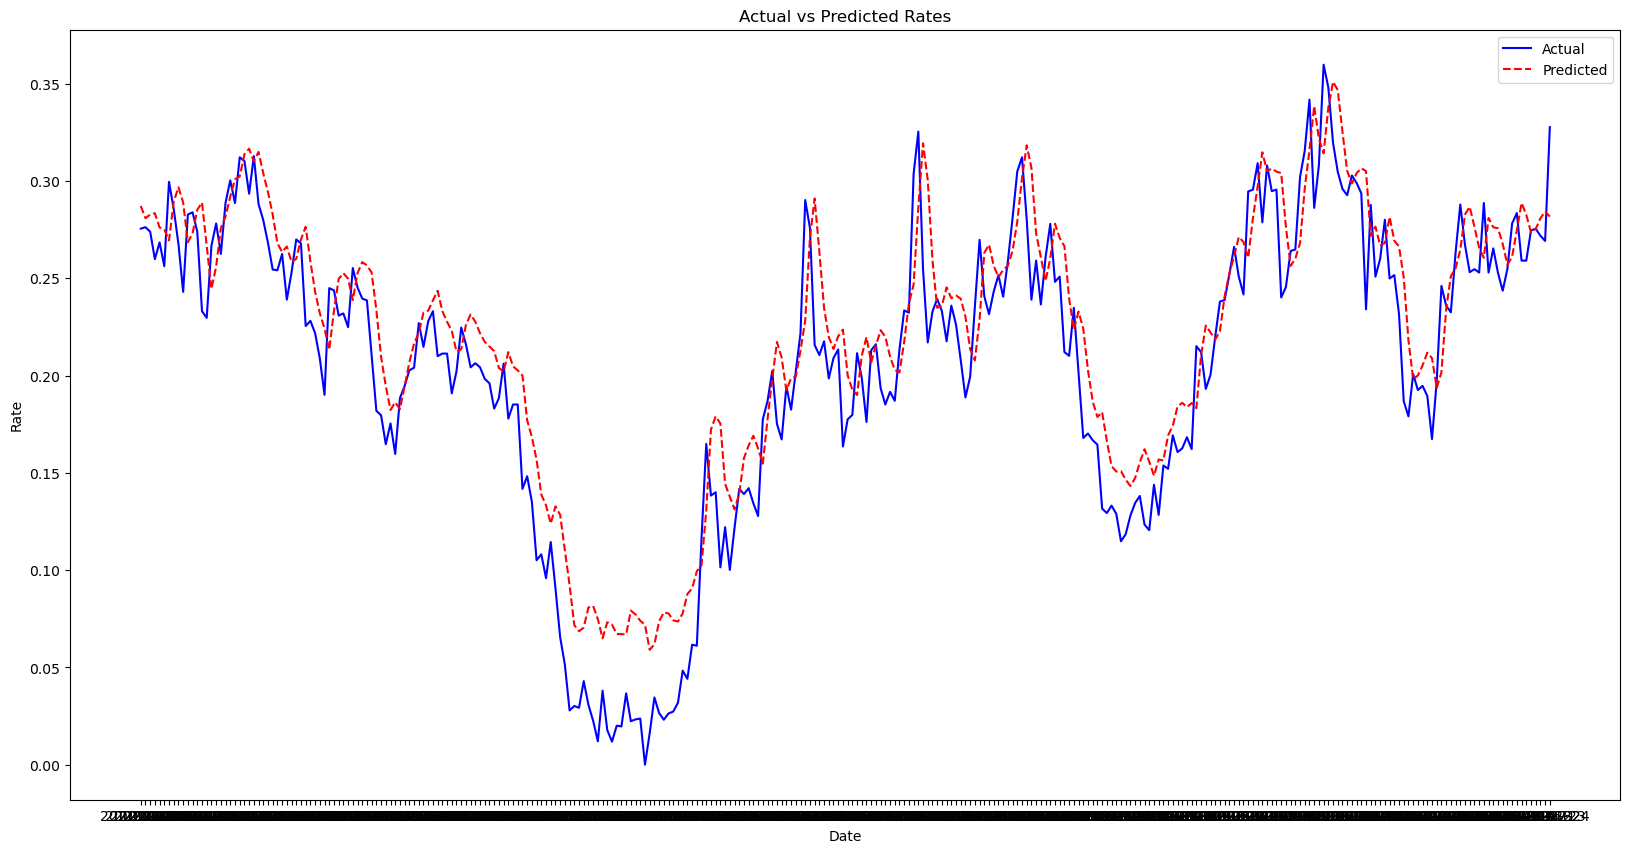

In [45]:
# Plotting the predicted rates
plt.figure(figsize=(20,10))
plt.plot(oxcg_test_dates, y_test_act, label=f'Actual', linestyle='-', color='blue')
plt.plot(oxcg_test_dates, y_test_oxcg, label=f'Predicted', linestyle='--', color='red')

plt.title('Actual vs Predicted Rates')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend(loc='best')
plt.show()